In [1]:
print("hello")

hello


In [2]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from backtesting import Strategy, Backtest
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'yfinance'

# Download the price data

In [15]:
def download_data_yfinance(ticker_symbol, timeframe, start_date, end_date):
    ticker = yf.Ticker(ticker_symbol)

    df = ticker.history(start=start_date, end=end_date, interval=timeframe)
    df.drop(columns=["Dividends", "Stock Splits"], inplace=True)
    df.index = df.index.tz_convert('Europe/Paris')
    df.to_csv(f"raw/{ticker_symbol.upper()}_{timeframe.upper()}_{start_date}_{end_date}.csv")

    print("Data downloaded successfully in Data folder.")

download_data_yfinance("META", "5m", "2025-02-01", "2025-03-10")

# Example ticker symbols: AAPL, MSFT, NVDA, TSLA, AMZN, GOOGL, FB ...
# Example timeframes: 1m, 5m, 15m, 30m, 1h, 1d
# Example start_date and end_date: 2025-02-01

Data downloaded successfully in Data folder.


In [16]:
df = pd.read_csv("raw/META_5M_2025-02-01_2025-03-10.csv")
pd.set_option('display.max_columns', None)
#print(df.info())
#print(df.head())
#print(len(df))

## Bollinger Scalping Strategy

### How the Strategy Works

- **Indicators Used:**  
  - **EMA:** Two exponential moving averages (30 and 50 periods) to detect trend direction.  
  - **ATR:** Measures candle size to set stop loss and take profit.  
  - **Bollinger Bands:** Based on 15 periods, used for a secondary signal.

- **Signals:**  
  - The DataFrame stores:
    - `0` = No signal  
    - `1` = Sell signal  
    - `2` = Buy signal  
  - Over a 7-candle window:
    - If `EMA_fast < EMA_slow` → Add `1` (bearish)  
    - If `EMA_fast > EMA_slow` → Add `2` (bullish)  
    - Else → Add `0`  
  - A second signal is triggered if the price deviates from the 15-period SMA by more than **1.5σ**.  
  - The final trading signal is the **intersection of both conditions**.

- **Trade Management:**  
  - Only one trade at a time (the previous position must be closed before opening a new one).  
  - Stop loss and take profit are set at entry, based on:
    - `TPSL` (Take Profit / Stop Loss ratio)  
    - `SL_coef` (Stop Loss coefficient derived from ATR)


In [ ]:
df = pd.read_csv("raw/META_5M_2025-02-01_2025-03-10.csv")

df=df[df['Volume']!=0] 
df.reset_index(drop=True,inplace=True)
df["EMA_slow"]=ta.ema(df.Close, length=50) 
df["EMA_fast"]=ta.ema(df.Close, length=30) 
df['RSI']=ta.rsi(df.Close, length=10) 
my_bbands = ta.bbands(df.Close, length=15, std=1.5)
df['ATR']=ta.atr(df.High, df.Low, df.Close, length=7) 
df = df.join(my_bbands, how='left')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

print(df.head())


                    Datetime        Open        High         Low       Close  \
0  2025-01-02 19:35:00+01:00  590.599976  592.190002  590.109985  591.489990   
1  2025-01-02 19:40:00+01:00  591.549988  593.229980  590.964111  593.229980   
2  2025-01-02 19:45:00+01:00  593.000000  593.593994  592.030029  592.409973   
3  2025-01-02 19:50:00+01:00  592.710022  592.760010  591.289978  591.525024   
4  2025-01-02 19:55:00+01:00  591.599976  593.659973  591.599976  593.659973   

   Volume    EMA_slow    EMA_fast        RSI       ATR  BBL_15_1.5  \
0   56130  596.386158  594.167291  43.065778  2.107654  589.494865   
1   62108  596.262387  594.106820  50.509582  2.130266  589.711488   
2   82290  596.111312  593.997346  47.273164  2.049335  589.866135   
3   50060  595.931457  593.837841  43.900175  1.966550  589.850214   
4   65810  595.842380  593.826366  52.907204  1.990614  589.820012   

   BBM_15_1.5  BBU_15_1.5  BBB_15_1.5  BBP_15_1.5  
0  591.674748  593.854630    0.736852    0.457

In [ ]:
### EMA Signal (Exponential Moving Average) ###

def ema_signal(df, current_candle, backcandles):
    start = max(0, current_candle - backcandles)
    end = current_candle
    relevant_rows = df.iloc[start:end]
    if all(relevant_rows["EMA_fast"] < relevant_rows["EMA_slow"]):
        return 1 
    elif all(relevant_rows["EMA_fast"] > relevant_rows["EMA_slow"]):
        return 2
    else:
        return 0

def total_signal(df, current_candle, backcandles):
    if (ema_signal(df, current_candle, backcandles)==2
        and df.Close[current_candle]<=df['BBL_15_1.5'][current_candle]):
            return 2
    if (ema_signal(df, current_candle, backcandles)==1
        and df.Close[current_candle]>=df['BBU_15_1.5'][current_candle]):
            return 1
    return 0

def pointpos(x):
    if x['TotalSignal']==1:
        return x['High']*1.01
    elif x['TotalSignal']==2:
        return x['Low']*0.99
    else:
        return 0

def SIGNAL():
    return df['TotalSignal']


df['EMASignal'] = df.apply(lambda row: ema_signal(df, row.name, 7) , axis=1)
df['TotalSignal'] = df.apply(lambda row: total_signal(df, row.name, 7), axis=1)
df['pointpos'] = df.apply(pointpos, axis=1)

print(df.head())

                    Datetime        Open        High         Low       Close  \
0  2025-01-02 19:35:00+01:00  590.599976  592.190002  590.109985  591.489990   
1  2025-01-02 19:40:00+01:00  591.549988  593.229980  590.964111  593.229980   
2  2025-01-02 19:45:00+01:00  593.000000  593.593994  592.030029  592.409973   
3  2025-01-02 19:50:00+01:00  592.710022  592.760010  591.289978  591.525024   
4  2025-01-02 19:55:00+01:00  591.599976  593.659973  591.599976  593.659973   

   Volume    EMA_slow    EMA_fast        RSI       ATR  BBL_15_1.5  \
0   56130  596.386158  594.167291  43.065778  2.107654  589.494865   
1   62108  596.262387  594.106820  50.509582  2.130266  589.711488   
2   82290  596.111312  593.997346  47.273164  2.049335  589.866135   
3   50060  595.931457  593.837841  43.900175  1.966550  589.850214   
4   65810  595.842380  593.826366  52.907204  1.990614  589.820012   

   BBM_15_1.5  BBU_15_1.5  BBB_15_1.5  BBP_15_1.5  EMASignal  TotalSignal  \
0  591.674748  593.85

# Strategy definition

In [ ]:
class ScalpingBollinger_5min(Strategy):
    initsize = 1
    mysize = initsize
    slcoef = 2.1
    TPSLRatio = 2.5
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)

    def next(self):
        super().next()
        slatr = self.slcoef*self.data.ATR[-1]
        TPSLRatio = self.TPSLRatio

        if self.signal1==2 and len(self.trades)==0:
            sl1 = self.data.Close[-1] - slatr
            tp1 = self.data.Close[-1] + slatr*TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=self.mysize)

        elif self.signal1==1 and len(self.trades)==0:
            sl1 = self.data.Close[-1] + slatr
            tp1 = self.data.Close[-1] - slatr*TPSLRatio
            self.sell(sl=sl1, tp=tp1, size=self.mysize)

# Backtesting

In [ ]:

def plot_signals(df):
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close']),

                go.Scatter(x=df.index, y=df['BBL_15_1.5'],
                           line=dict(color='green', width=1),
                           name="BBL"),
                go.Scatter(x=df.index, y=df['BBU_15_1.5'],
                           line=dict(color='green', width=1),
                           name="BBU"),
                go.Scatter(x=df.index, y=df['EMA_fast'],
                           line=dict(color='black', width=1),
                           name="EMA_fast"),
                go.Scatter(x=df.index, y=df['EMA_slow'],
                           line=dict(color='blue', width=1),
                           name="EMA_slow")])
    df_filtered = df[df["pointpos"]!=0]
    fig.add_scatter(x=df_filtered.index, y=df_filtered["pointpos"], mode="markers",
                marker=dict(size=5, color="MediumPurple"),
                name="entry")
    fig.show()

def SIGNAL():
    return df['TotalSignal']

def run_strategy(df,strategy,cash=100,margin=1/50,commission=.00):
    bt = Backtest(df, strategy, cash=cash, margin=margin, commission=commission)
    stat = bt.run()
    print(stat)
    fig = bt.plot()


In [ ]:
plot_signals(df)

In [ ]:
run_strategy(df,ScalpingBollinger_5min, cash=100, margin=1/10, commission=.00)

<ipython-input-30-a25593ae9c0f>:31: UserWarning:

Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).

<ipython-input-30-a25593ae9c0f>:31: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.



Start                                     0.0
End                                    1899.0
Duration                               1899.0
Exposure Time [%]                   78.736842
Equity Final [$]                   172.727368
Equity Peak [$]                    180.949295
Return [%]                          72.727368
Buy & Hold Return [%]                20.75606
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -32.546226
Avg. Drawdown [%]                   -4.669854
Max. Drawdown Duration                  534.0
Avg. Drawdown Duration              46.394737
# Trades                                 42.0
Win Rate [%]                        33.333333
Best Trade [%]                       4.205598
Worst Trade [%]                     -1.752018
Avg. Trade [%]                    

# Optimisation des paramètres de la stratégie

<ipython-input-11-71f9cbe026e7>:2: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt = Backtest(df, strategy, cash=cash, margin=margin, commission=commission)
<ipython-input-11-71f9cbe026e7>:2: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(df, strategy, cash=cash, margin=margin, commission=commission)
/usr/local/lib/python3.11/dist-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 441 configurations.
  output = _optimize_grid()


Backtest.optimize:   0%|          | 0/3 [00:00<?, ?it/s]

Start                                     0.0
End                                    1899.0
Duration                               1899.0
Exposure Time [%]                   80.157895
Equity Final [$]                   219.513275
Equity Peak [$]                    221.513275
Return [%]                         119.513275
Buy & Hold Return [%]                20.75606
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -21.376597
Avg. Drawdown [%]                   -3.758399
Max. Drawdown Duration                  269.0
Avg. Drawdown Duration               31.37037
# Trades                                 42.0
Win Rate [%]                        35.714286
Best Trade [%]                       4.325758
Worst Trade [%]                     -2.940774
Avg. Trade [%]                    

<ipython-input-11-71f9cbe026e7>:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("optimization.png")
<ipython-input-11-71f9cbe026e7>:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("optimization.png")
<ipython-input-11-71f9cbe026e7>:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("optimization.png")
<ipython-input-11-71f9cbe026e7>:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("optimization.png")
<ipython-input-11-71f9cbe026e7>:

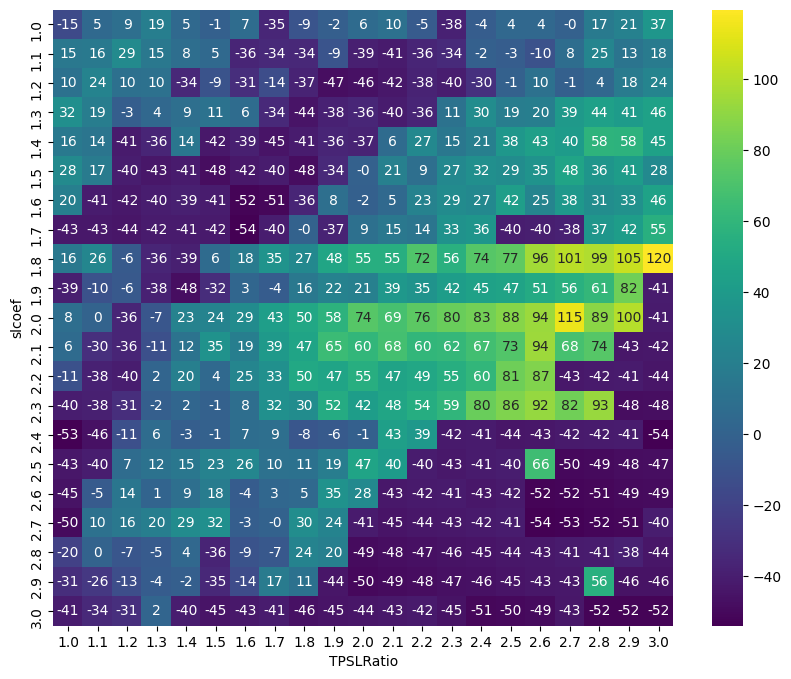

In [ ]:
def optimize_strategy(df,strategy, cash=100, margin=1/10, commission=.00):
    bt = Backtest(df, strategy, cash=cash, margin=margin, commission=commission)
    stats,heatmap = bt.optimize(slcoef = [i/10 for i in range(10, 31)], TPSLRatio = [i/10 for i in range(10, 31)],
    maximize = 'Return [%]', max_tries = 500,random_state = 0, return_heatmap=True)
    print(stats)
    print(stats["_strategy"])
    heatmap_df = heatmap.unstack()
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_df, cmap='viridis', annot=True, fmt=".0f")
    plt.savefig("optimization.png")
    plt.show()

optimize_strategy(df,ScalpingBollinger_5min, cash=100, margin=1/10, commission=.00)

# A vous de contruire votre stratégie !

In [ ]:
### IMPORTEZ VOS DONNEES ###
# Choisissez celles que vous souhaitez
#df = pd.read_csv("https://raw.githubusercontent.com/julienwax/Trading-workshops/main/trading-workshop2/Data/AAPL_5M_2025-01-01_2025-02-15.csv")  # Apple
#df = pd.read_csv("https://raw.githubusercontent.com/julienwax/Trading-workshops/main/trading-workshop2/Data/NVDA_5M_2025-01-01_2025-02-15.csv")  # Nvidia
#df = pd.read_csv("https://raw.githubusercontent.com/julienwax/Trading-workshops/main/trading-workshop2/Data/META_5M_2025-01-01_2025-02-10.csv")  # Meta

# Vous avez les données de AAPL, MSFT, NVDA, META déjà téléchargées dans le dossier Data mais vous pouvez en
# télécharger d'autres avec la fonction download_data_yfinance() (je vous conseille en timeframe 5m) (il y a des fois des bugs avec le nombre de requêtes)

Dans la stratégie précédente, on a utilisé deux paramètres pour gérer nos trades:
- $TPSL$ (Take Profit to Stop Loss ratio) définie par $$ TPSL = \frac{TP_{distance}}{SL_{distance}} $$ où $TP_{distance}$ désigne l'écart de prix entre le prix actuel et le take profit du trade que l'on lance, idem pour $SL_{distance}$ avec le stop loss.

- $SL_{coef}$, en général j'ajoute l'indicateur ATR (Average True Range), c'est la moyenne de la taille des bougies précédentes dans mes données. Le coef précédent permet de calculer notre stop loss selon la formule (pour un LONG):
$$ SL = prix - SL_{coef}*ATR_{actuel}~~et~~TP = prix + SL_{coef}*ATR_{actuel}*TPSL$$

Cette approche permet de grandement simplifier la situation, on a juste à se poser la question quand est-ce que je rentre dans un
trade mais pas quand je sors, car les stop loss et take profit sont définis au moment d'entrer dans le trade. De plus ici pour simplifier
on ne gère qu'un trade à la fois, on attend que le précédent soit fermé avant d'en lancer un autre.
C'est un exemple simple vous pouvez choisir des paramètres qui vous semblent plus judicieux !

In [ ]:
### TRAITEZ VOS DONNEES ###
# Par exemple, enlever les colonnes sans volumes:
# df = df[df['Volume']!=0]
# df.reset_index(drop=True,inplace=True) # remettre l'index en ordre

# Ajouter des indicateurs:
# df["EMA_slow"]=ta.ema(df.Close, length=50) # Moyenne mobile exponentielle sur 50 périodes
# Exemple d'indicateurs:
# df['ATR']=ta.atr(df.High, df.Low, df.Close, length=7)
# df['RSI']=ta.rsi(df.Close, length=10) # Indicateur RSI sur 10 périodes (Relative Strength Index)
# en gros RSI > 70 = marché en surachat, RSI < 30 = marché en survente (peut-être pertinent ou peut-être pas), à vous de voir
# df['MACD']=ta.macd(df.Close)[0] # Indicateur MACD (Moving Average Convergence Divergence)
# Calcule la différence entre deux moyennes mobiles exponentielles (EMA) (12 et 26 périodes), n'hésitez pas à CHATGpt pour les détails
# df['BBANDS']=ta.bbands(df.Close, length=20, std=2) # Bandes de Bollinger
# df = df.join(my_bbands, how='left') # On ajoute les bandes de Bollinger au dataframe
# Bollinger Bands = Plusieurs moyennes mobiles simples décalées d'un nombre d'écarts-types (std) de la moyenne mobile simple
# df['SMA']=ta.sma(df.Close, length=20) # Moyenne mobile simple

## N'hésitez pas à regarder la documentation de pandas_ta pour plus d'indicateurs et en utiliser d'autres.
# df.dropna(inplace=True)
# df.reset_index(drop=True, inplace=True)
# Pour enlever les lignes vides et remettre les index en ordre


# Signaux

Maintenant une approche simple consiste à définir des signaux en fonction de plusieurs conditions et de les
ajouter aux données.
L'idée c'est que quand tous les signaux sont verts et qu'aucun ordre n'est en cours, on trade.

N'hésitez pas à vous référer à la première stratégie pour la syntaxe et les idées.

On peut faire comme avant dans la colonne du signal:

- 0 = pas de signal
- 1 = signal SHORT (vente)
- 2 = signal LONG (achat)

Je vous conseille après définir l'intersection de vos signaux dans une colonne 'TotalSignal'.

In [ ]:
### DEFINISSEZ VOS SIGNAUX D'ACHAT ET DE VENTE ###

# Pour faire simple, on peut s'inspirer des fonctions en commentaire

def signal_1(df,current_candle,backcandles):
    ...
    if ...
        return 1
    elif ...
        return 2
    else:
        return 0

def signal_2(df,current_candle,backcandles):
    ...
    if ...
        return 1
    elif ...
        return 2
    else:
        return 0

def total_signal(df,current_candle,backcandles):
    if (signal_1(df,current_candle,backcandles)==2
        and signal_2(df,current_candle,backcandles)==2
        ):
            return 2
    elif (signal_1(df,current_candle,backcandles)==1
        and signal_2(df,current_candle,backcandles)==1
        ):
            return 1
    else:
        return 0

length = ...
df["signal1"] = df.apply(lambda row: signal_1(df, row.name, length) , axis=1)
df["signal2"] = df.apply(lambda row: signal_2(df, row.name, length) , axis=1)
df["TotalSignal"] = df.apply(lambda row: total_signal(df, row.name, length) , axis=1)






In [ ]:
### Fonctions utiles pour la suite ###

def SIGNAL():
    return df['TotalSignal']

def pointpos(x):
    if x['TotalSignal']==1:
        return x['High']*1.01
    elif x['TotalSignal']==2:
        return x['Low']*0.99
    else:
        return 0

In [ ]:
# Affichage du backtest

def plot_signals(df):
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close']),

                go.Scatter(x=df.index, y=df['...'],
                           line=dict(color='green', width=1),
                           name="..."),
                go.Scatter(x=df.index, y=df['...'],
                           line=dict(color='green', width=1),
                           name="..."),
                go.Scatter(x=df.index, y=df['...'],
                           line=dict(color='black', width=1),
                           name="..."),
                go.Scatter(x=df.index, y=df['...'],
                           line=dict(color='blue', width=1),
                           name="...")])
    df_filtered = df[df["pointpos"]!=0]
    fig.add_scatter(x=df_filtered.index, y=df_filtered["pointpos"], mode="markers",
                marker=dict(size=5, color="MediumPurple"),
                name="entry")
    fig.show()

In [ ]:
### Definition de votre stratégie ###

class YourStrat(Strategy):
    initsize = 1
    mysize = initsize
    commission = 0.00
    parametre1 = ...            # Essayez d'introduire des paramètres pour optimiser votre stratégie (Pas évident)
    parametre2 = ...
    def init(self):
        super().init()
        self.signal1 = self.I(SIGNAL)
        #df['RSI']=ta.rsi(df.Close, length=self.rsi_length)

    def next(self):
        super().next()
        slatr = self.slcoef*self.data.ATR[-1]
        TPSLRatio = self.TPSLRatio

        # if len(self.trades)>0:                Fermetures des trades si le marché est en surachat ou survente
        #     if self.trades[-1].is_long and self.data.RSI[-1]>=90:
        #         self.trades[-1].close()
        #     elif self.trades[-1].is_short and self.data.RSI[-1]<=10:
        #         self.trades[-1].close()

        if self.signal1==2 and len(self.trades)==0:  # Définissez vos stoploss et takeprofits au moment de placer un ordre
            sl1 = ...
            tp1 = ...
            self.buy(sl=sl1, tp=tp1, size=self.mysize)

        elif self.signal1==1 and len(self.trades)==0:
            sl1 = ...
            tp1 = ...
            self.sell(sl=sl1, tp=tp1, size=self.mysize)

- "Margin" représente l'effet de levier en gros :  $margin = \frac{1}{10} \Leftrightarrow effet~de~levier = \times10 $

In [ ]:
### BACKTESTEZ VOTRE STRATEGIE ###

def run_strategy(df,strategy,cash=100,margin=1/50,commission=.00):
    bt = Backtest(df, strategy, cash=cash, margin=margin, commission=commission)
    stat = bt.run()
    print(stat)
    fig = bt.plot()

run_strategy(df,YourStrat, cash=100, margin=1/10, commission=.00)

In [ ]:
### OPTIMISEZ VOTRE STRATEGIE ###
# Vous pouvez optimiser votre stratégie en changeant les paramètres de la fonction optimize_strategy

def optimize_your_strategy(df,strategy, cash=100, margin=1/10, commission=.00):
    bt = Backtest(df, strategy, cash=cash, margin=margin, commission=commission)
    stats,heatmap = bt.optimize(... = [i/10 for i in range(10, 31)], ... = [i/10 for i in range(10, 31)],
    maximize = 'Return [%]', max_tries = 500,random_state = 0, return_heatmap=True) # Vous pouvez changer les paramètres et la taille de la grille ici
    print(stats)
    print(stats["_strategy"])
    heatmap_df = heatmap.unstack()
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_df, cmap='viridis', annot=True, fmt=".0f")
    plt.savefig("optimization.png")
    plt.show()


optimize_your_strategy(df,YourStrat, cash=100, margin=1/10, commission=.00)


# Pistes pour aller plus loin

- Essayer d'obtenir des données plus fournies et implémenter des stratégies avec des timeframes plus petits.

- Générer des signaux avec avec un réseau de neurones récurrent. (Peut-être dans les prochains ateliers)

- Obtenir des stratégies avec un trade management plus élaboré que simplement avoir un stop loss et un take profit.

- Gérer plusieurs ordres à la fois et trader sur plusieurs actifs à la fois avec un même portefeuille.